# Generative Models PHW4: Energy-Based Models

Name: Ali Ghasemzadeh

Student ID: 401106339

## Setup

In [41]:
# hyper parameters :
batch_size = 64

In [42]:
# Import necessary libraries
import random
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

In [43]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (10 points)

Load the `MNIST` dataset and normalize the images between -1 and 1 as this makes the implementation easier.

In [44]:
# TODO: Define transformations and set the batch size
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

# TODO: Load train and test datasets
trainset = MNIST(root='./data', train=True, download=True, transform=transform)
testset = MNIST(root='./data', train=False, download=True, transform=transform)

# TODO: Load the train and test loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [45]:
for batch in trainloader:
    print(batch[0].shape)
    print(batch[1].shape)
    break


torch.Size([64, 784])
torch.Size([64])


# Langevin Dynamics (20 points)

The Langevin dynamics in our case starts with a randomly initialized $x_0$ and then uses the information about the landscape of the energy function
(i.e., the gradient) to seek for new $x$, that is:
$$x_{t+1} = x_{t} + \alpha \nabla_{x_t}\text{LogSumExp} \left[f_{\theta} (x) \right] + \sigma \cdot \epsilon$$

where $\alpha, \sigma > 0$ and $\epsilon \sim \mathcal{N}(0, I)$. The Langevin dynamics could be seen as the stochastic gradient descent in the observable space with a small Gaussian noise added at each step.

Our goal is to run the Langevin dynamics for $\eta$ iterations with the steps size $\alpha$ and the noise level equal $\sigma$.

In [46]:
def energy_gradient(model, x):
    model.eval()
    x_t = x.clone().detach().requires_grad_(True)
    x_t_grad = torch.autograd.grad(torch.logsumexp(model(x_t), 1).sum(), [x_t], retain_graph=True)[0]
    model.train()
    return x_t_grad.to(device)

In [47]:
def langevin_dynamics_step(model, x, alpha, sigma):
    gradient = energy_gradient(model, x)
    epsilon = (torch.randn_like(x))
    new_x = x + alpha * gradient + epsilon * sigma
    return new_x

# Sampling (15 points)

In [48]:
def sample(model, eta, alpha, sigma, shape):
    x = (torch.rand((shape, 28 * 28)) * 2 - 1).to(device)
    for _ in range(eta):
        x = langevin_dynamics_step(model, x, alpha, sigma)
    return x

# Loss (15 points)

We can evaluate our model using the following objective:

$$\mathcal{L} = \mathcal{L}_\text{clf}(\theta) + \mathcal{L}_\text{gen}(\theta)$$

Where $\mathcal{L}_\text{clf}(\theta)$ is the cross-entropy loss and $\mathcal{L}_\text{gen}(\theta)$ is an approximation to the log-marginal distribution over images (for example the LogSumExp loss).

In [49]:
def loss_function(model, eta, alpha, sigma, x, y_pred, y_true):
    y_pred_sm = torch.softmax(y_pred, 1)
    nll = nn.NLLLoss(reduction='none')
    L_clf = nll(torch.log(y_pred_sm), y_true).mean()
    
    x_sample = sample(model, eta, alpha, sigma, x.shape[0])
    f_x_sample_y = model(x_sample)
    L_G = -(torch.logsumexp(y_pred, dim=1) - torch.logsumexp(f_x_sample_y, dim=1)).mean()
    return L_clf + L_G, L_clf, L_G

# Neural Network (10 points)

Define the neural network that specifies the energy function.
The inputs should be images and the outputs must be the classes.
Don't forget to use appropriate activation functions!

In [50]:
class EnergyNet(nn.Module):
    def __init__(self, D=28*28, M=256, K=10):
        super(EnergyNet, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(D, M), nn.ELU(),
            nn.Linear(M, M), nn.ELU(),
            nn.Linear(M, M), nn.ELU(),
            nn.Linear(M, K)
        )

    def forward(self, x):
        return self.network(x)

# Visualize (15 points)

Create the following functions to be able to visualize real and generated images.

In [51]:
def visualize_real(loader):
    images, labels = next(iter(loader))
    images = images.reshape(-1, 28, 28)  # Reshape images to 28x28

    plt.figure(figsize=(10, 10))
    for i in range(16):  # Display the first 16 images in the batch
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

def visualize_generated(model, eta, alpha, sigma, loader):
    images, _ = next(iter(loader))
    generated_images = sample(model, eta, alpha, sigma, images.shape[0])
    generated_images = generated_images.reshape(-1, 28, 28).detach().cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(16):  # Display the first 16 generated images
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.title('Generated')
        plt.axis('off')
    plt.show()

# Training (15 points)

Fill in the evaluation and training functions. Make sure you track the loss and plot it to analyze possible issues.

In [52]:
def eval_ebm(model, loader, eta, alpha, sigma):
    model.eval()
    total_loss = 0
    total_samples = 0
    progress_bar = tqdm(loader, desc="Evaluating")
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss, L_clf, L_g = loss_function(model, eta, alpha, sigma, x, y_pred, y)
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        progress_bar.set_postfix({'val_loss':loss.item(), 'clf_loss : ' : L_clf.item(), 'gen_loss : ' : L_g.item()})
    
    return total_loss / total_samples


import imageio
import os

def train_ebm(model, optimizer, train_loader, val_loader, epochs, eta, alpha, sigma, save_dir='training_images'):
    train_losses = []
    val_losses = []
    image_paths = []  # To store paths of saved images

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")
        for x, y in progress_bar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss, L_clf, L_g = loss_function(model, eta, alpha, sigma, x, y_pred, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
            progress_bar.set_postfix({'train_loss': loss.item(), 'clf_loss': L_clf.item(), 'gen_loss': L_g.item()})
        
        train_loss = total_loss / total_samples
        val_loss = eval_ebm(model, val_loader, eta, alpha, sigma)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        visualize_generated(model, eta, alpha, sigma, train_loader)
        # Generate and save images
        generated_images = sample(model, eta, alpha, sigma, 16)  # Assuming we want to generate 16 images
        generated_images = generated_images.reshape(-1, 28, 28).detach().cpu().numpy()
        img_path = os.path.join(save_dir, f'epoch_{epoch+1}.png')
        save_image_grid(generated_images, img_path)
        image_paths.append(img_path)
        torch.save(model, "model.pth")

    # Create GIF
    create_gif(image_paths, os.path.join(save_dir, 'training.gif'))

    return train_losses, val_losses

def save_image_grid(images, path, rows=4, cols=4):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5, 5))
    for ax, img in zip(axes.flat, images):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

def create_gif(image_paths, gif_path):
    with imageio.get_writer(gif_path, mode='I', duration=0.5) as writer:
        for image_path in image_paths:
            image = imageio.imread(image_path)
            writer.append_data(image)


Now define the optimizer and train your model.

Evaluating: 100%|██████████| 157/157 [00:18<00:00,  8.59it/s, val_loss=1.18, clf_loss : =0.471, gen_loss : =0.709]   


Epoch 1/25, Train Loss: 0.9340, Val Loss: 0.8561


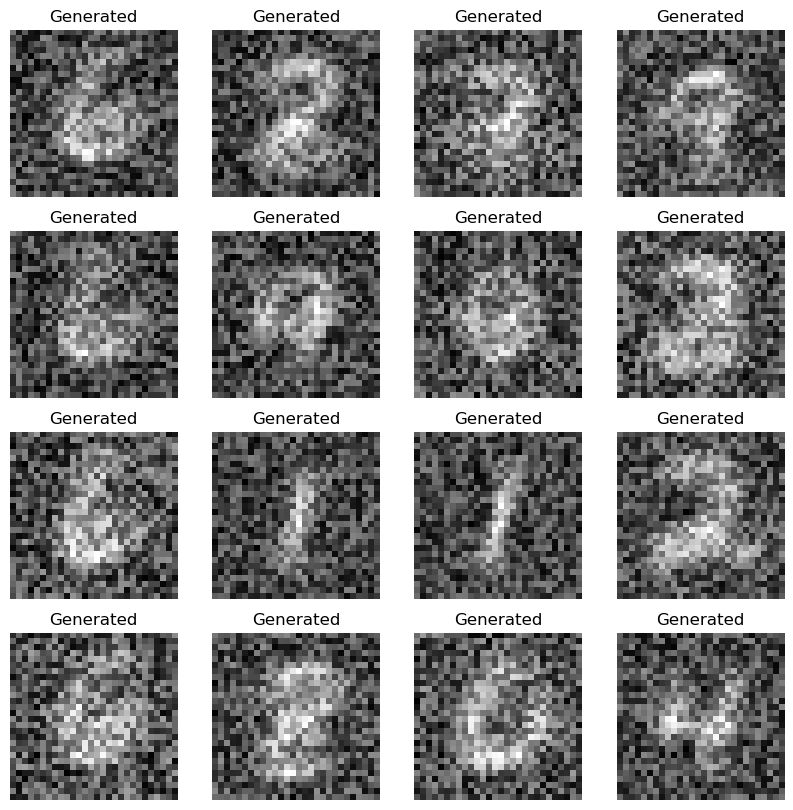

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.03it/s, val_loss=0.323, clf_loss : =0.354, gen_loss : =-0.0312] 


Epoch 2/25, Train Loss: 0.6834, Val Loss: 0.3486


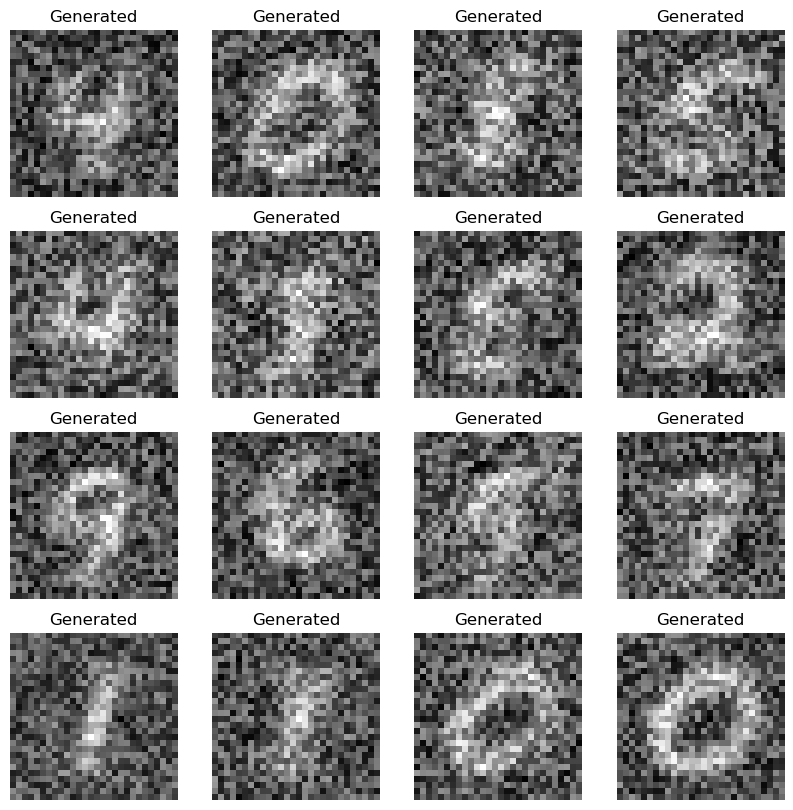

Evaluating: 100%|██████████| 157/157 [00:18<00:00,  8.31it/s, val_loss=-0.516, clf_loss : =0.285, gen_loss : =-0.801]  


Epoch 3/25, Train Loss: 0.5510, Val Loss: 0.4291


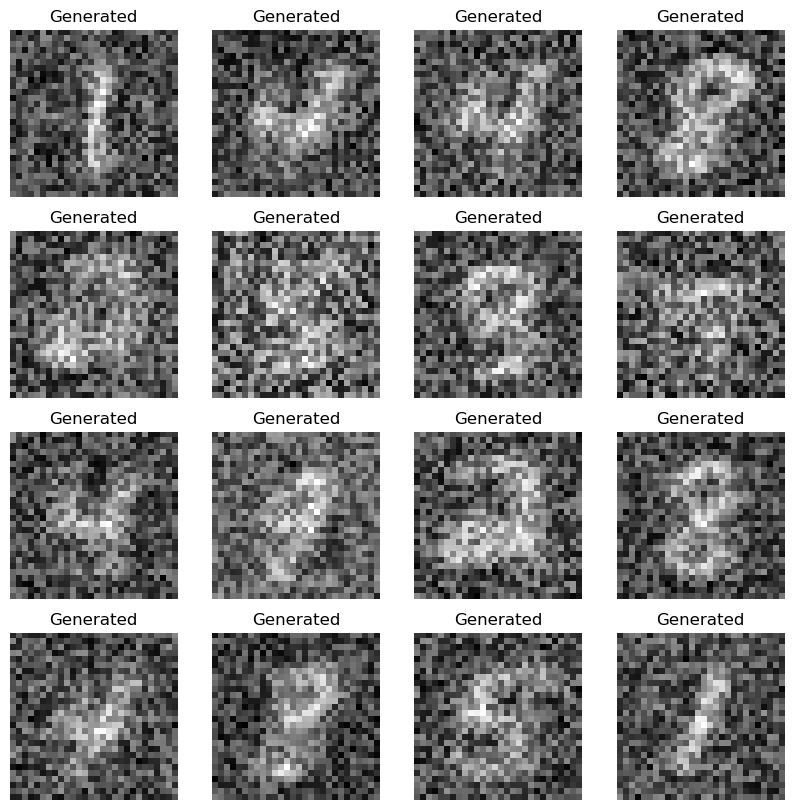

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.02it/s, val_loss=0.204, clf_loss : =0.229, gen_loss : =-0.0251]   


Epoch 4/25, Train Loss: 0.4829, Val Loss: 0.5198


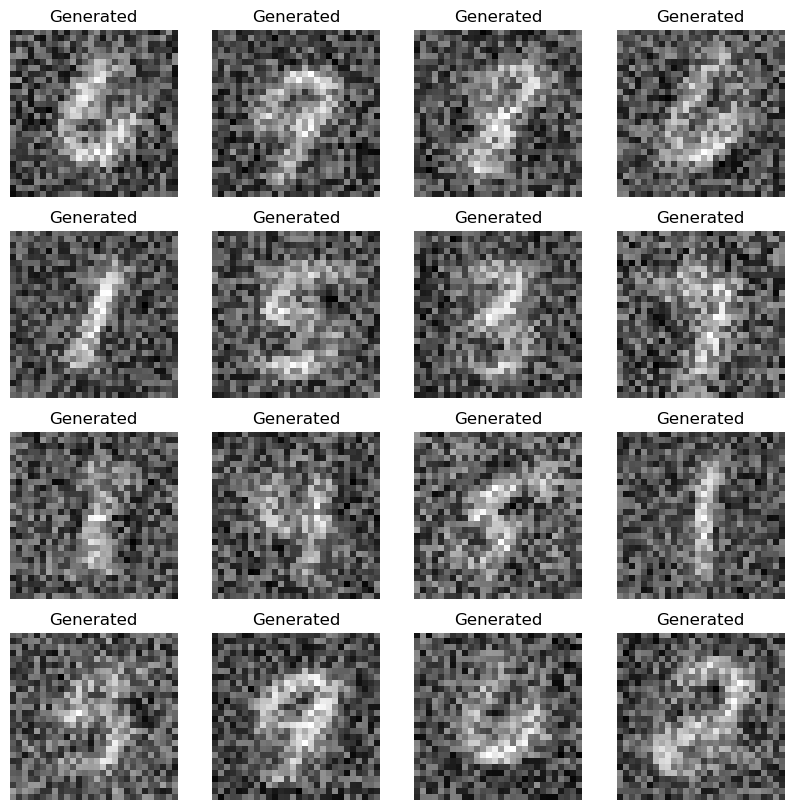

Evaluating: 100%|██████████| 157/157 [00:17<00:00,  8.76it/s, val_loss=0.17, clf_loss : =0.215, gen_loss : =-0.0448]   


Epoch 5/25, Train Loss: 0.4496, Val Loss: 0.3267


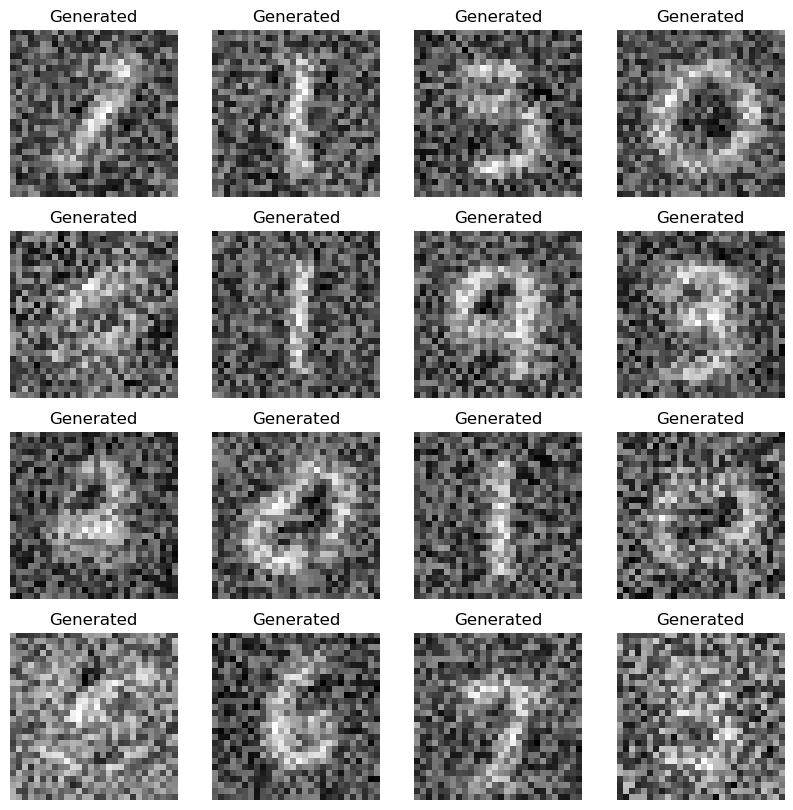

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.19it/s, val_loss=0.264, clf_loss : =0.193, gen_loss : =0.0708]   


Epoch 6/25, Train Loss: 0.4189, Val Loss: 0.3980


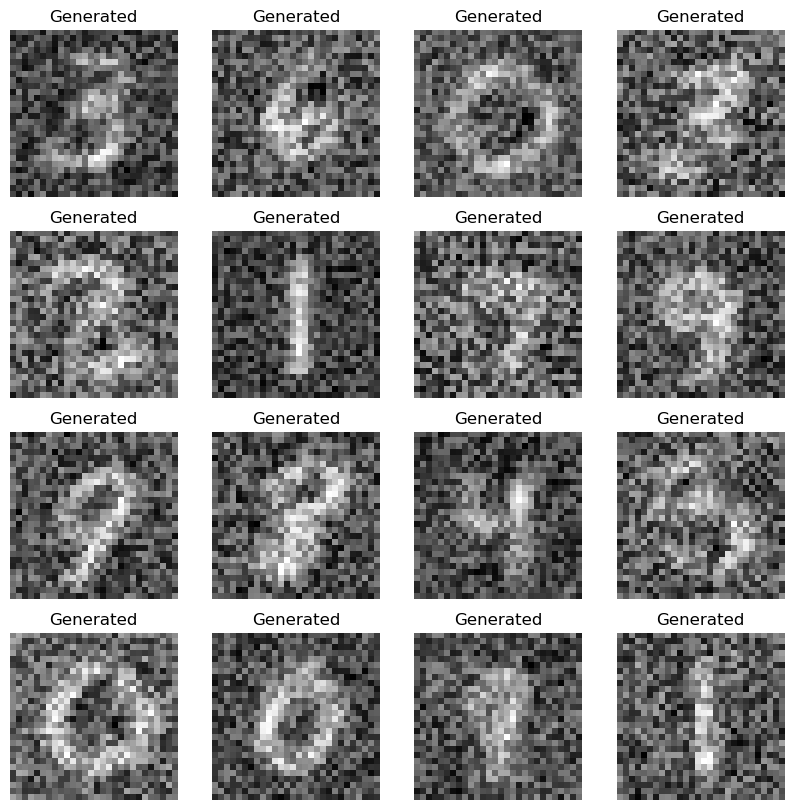

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.12it/s, val_loss=0.577, clf_loss : =0.19, gen_loss : =0.387]     


Epoch 7/25, Train Loss: 0.3976, Val Loss: 0.4808


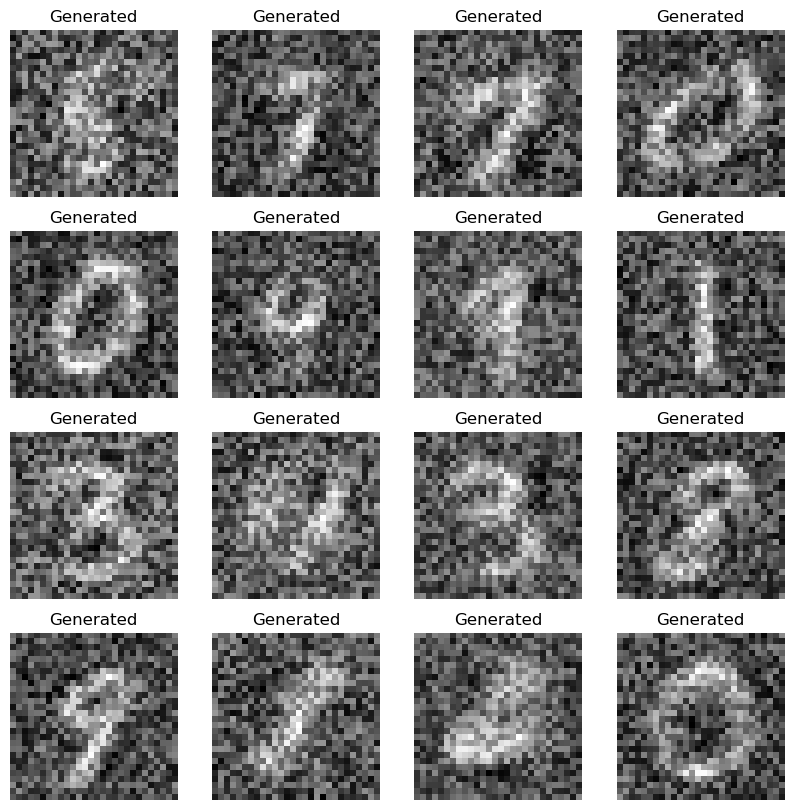

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.14it/s, val_loss=1.9, clf_loss : =0.191, gen_loss : =1.71]      


Epoch 8/25, Train Loss: 0.3756, Val Loss: 0.6052


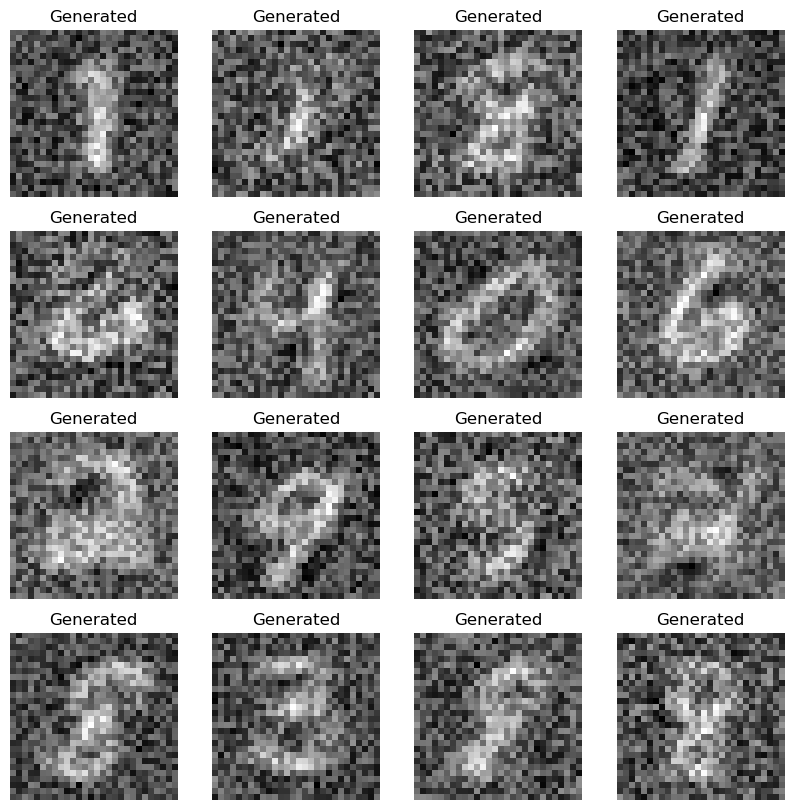

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.11it/s, val_loss=0.593, clf_loss : =0.186, gen_loss : =0.408]    


Epoch 9/25, Train Loss: 0.3637, Val Loss: 0.2174


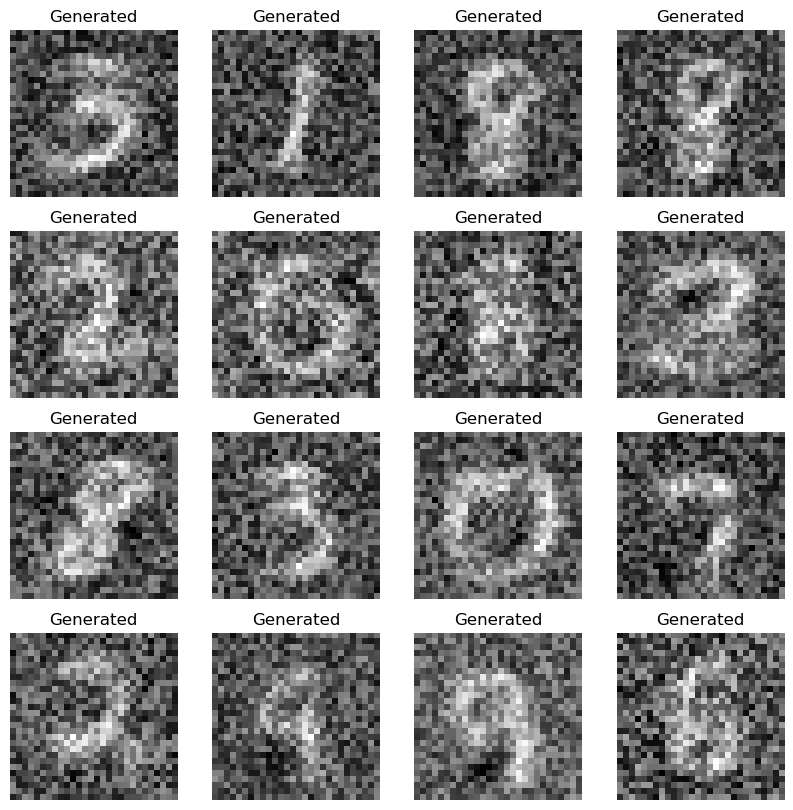

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.06it/s, val_loss=0.243, clf_loss : =0.147, gen_loss : =0.0965]    


Epoch 10/25, Train Loss: 0.3421, Val Loss: 0.3206


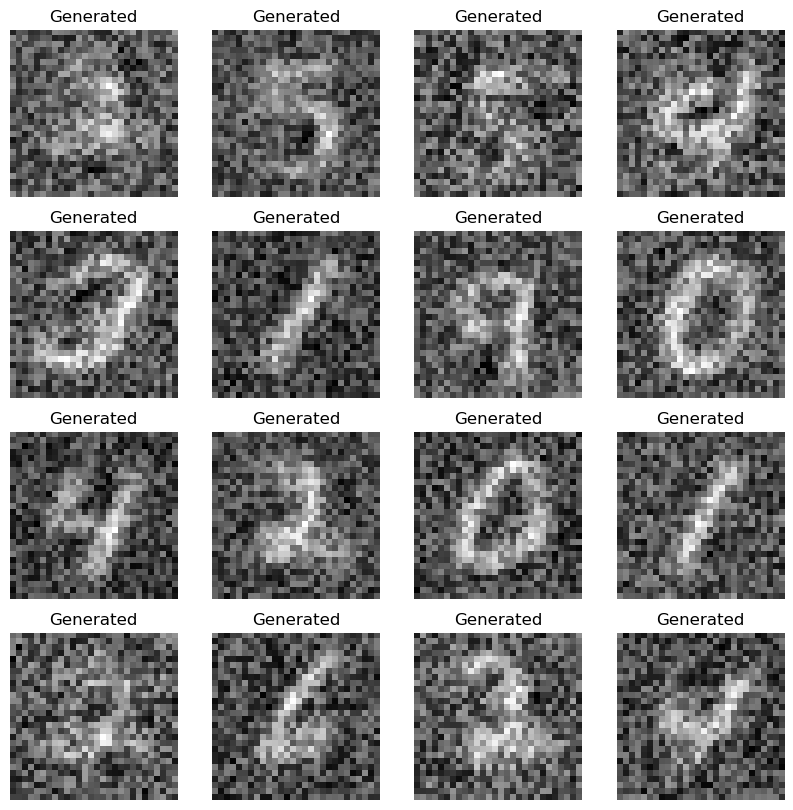

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.14it/s, val_loss=-0.282, clf_loss : =0.14, gen_loss : =-0.422]   


Epoch 11/25, Train Loss: 0.3325, Val Loss: 0.4280


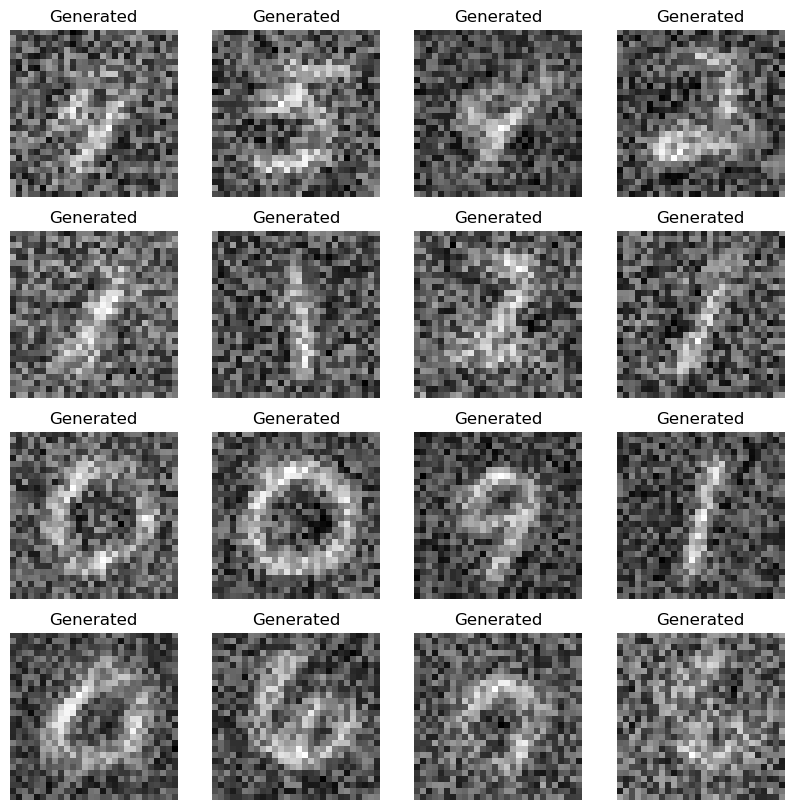

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.13it/s, val_loss=0.685, clf_loss : =0.132, gen_loss : =0.553]      


Epoch 12/25, Train Loss: 0.3180, Val Loss: 0.5202


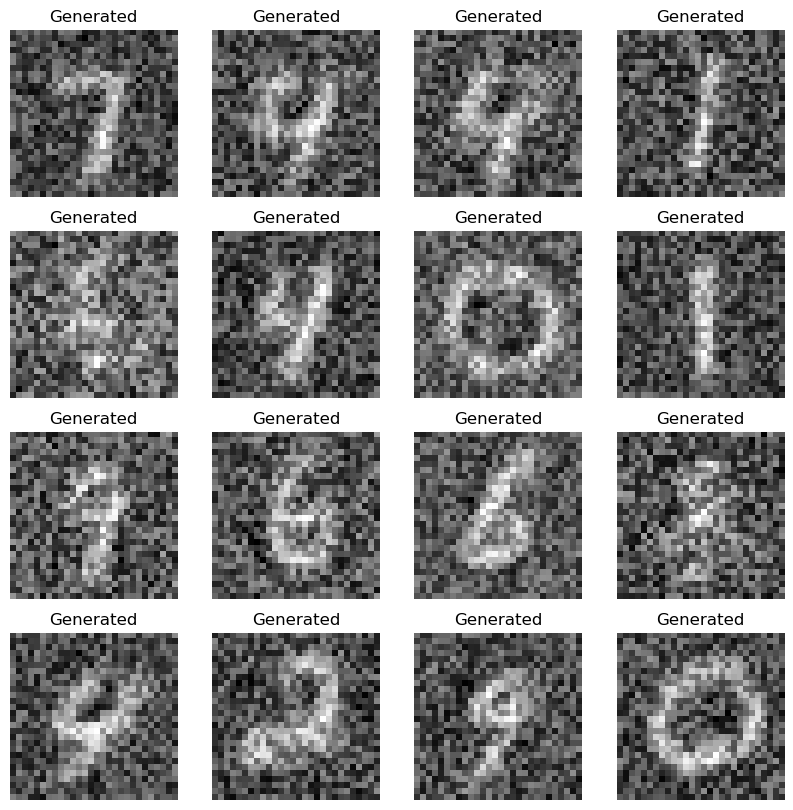

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.13it/s, val_loss=0.0381, clf_loss : =0.126, gen_loss : =-0.0878]  


Epoch 13/25, Train Loss: 0.3064, Val Loss: 0.3626


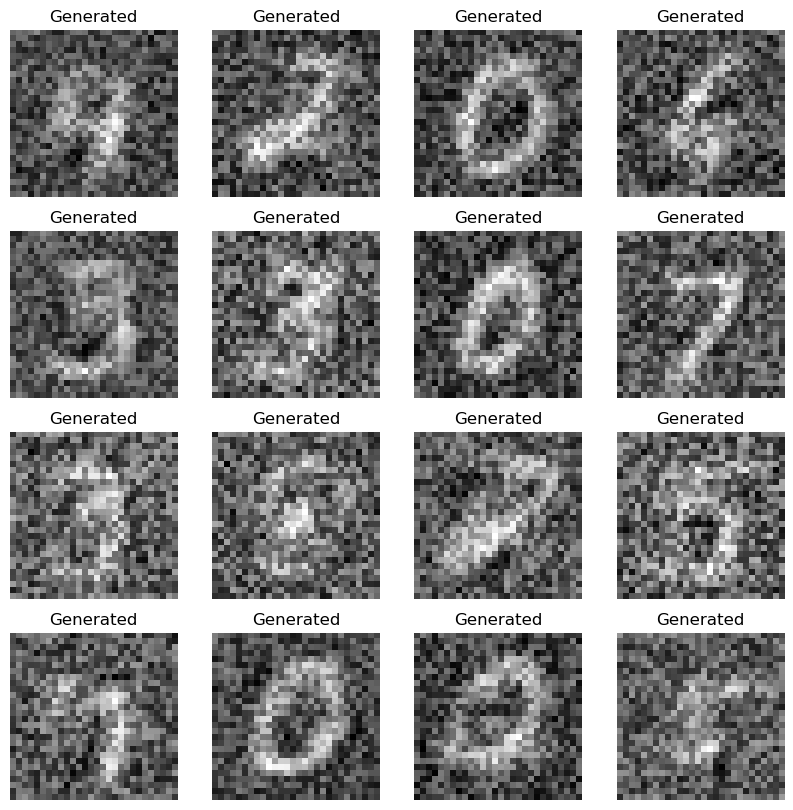

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.05it/s, val_loss=0.408, clf_loss : =0.119, gen_loss : =0.29]      


Epoch 14/25, Train Loss: 0.2912, Val Loss: 0.2323


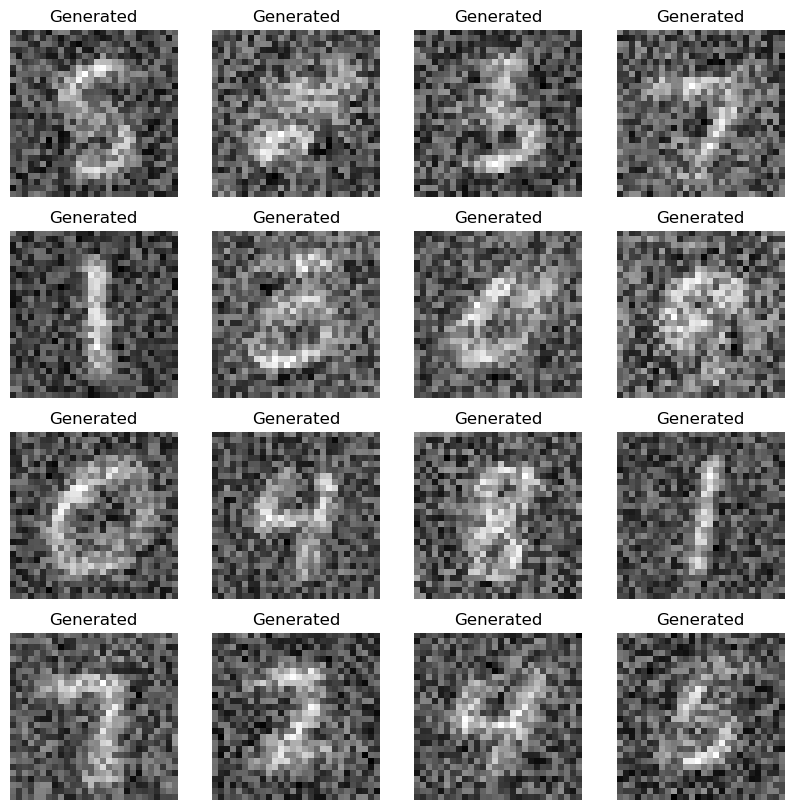

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.03it/s, val_loss=0.172, clf_loss : =0.0918, gen_loss : =0.0803]    


Epoch 15/25, Train Loss: 0.2820, Val Loss: 0.3619


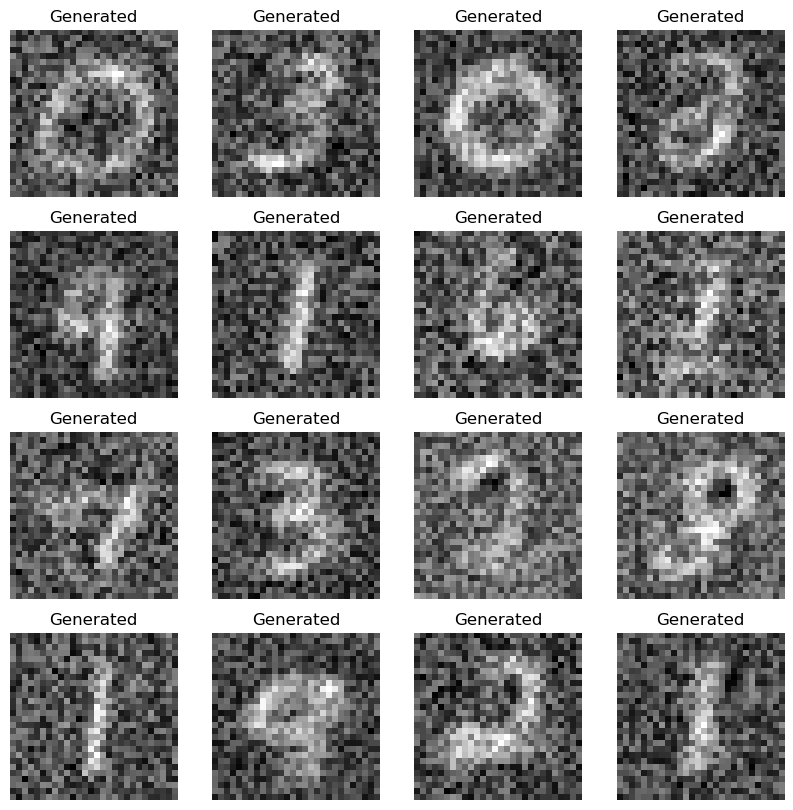

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.16it/s, val_loss=0.587, clf_loss : =0.119, gen_loss : =0.468]      


Epoch 16/25, Train Loss: 0.2720, Val Loss: 0.4279


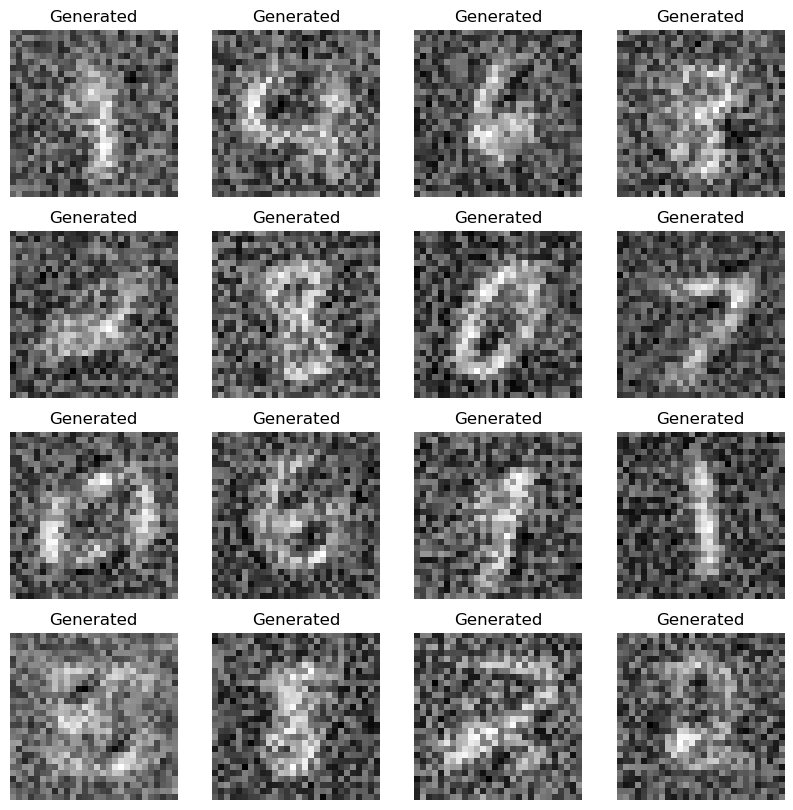

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.19it/s, val_loss=0.586, clf_loss : =0.0823, gen_loss : =0.503]    


Epoch 17/25, Train Loss: 0.2616, Val Loss: 0.5237


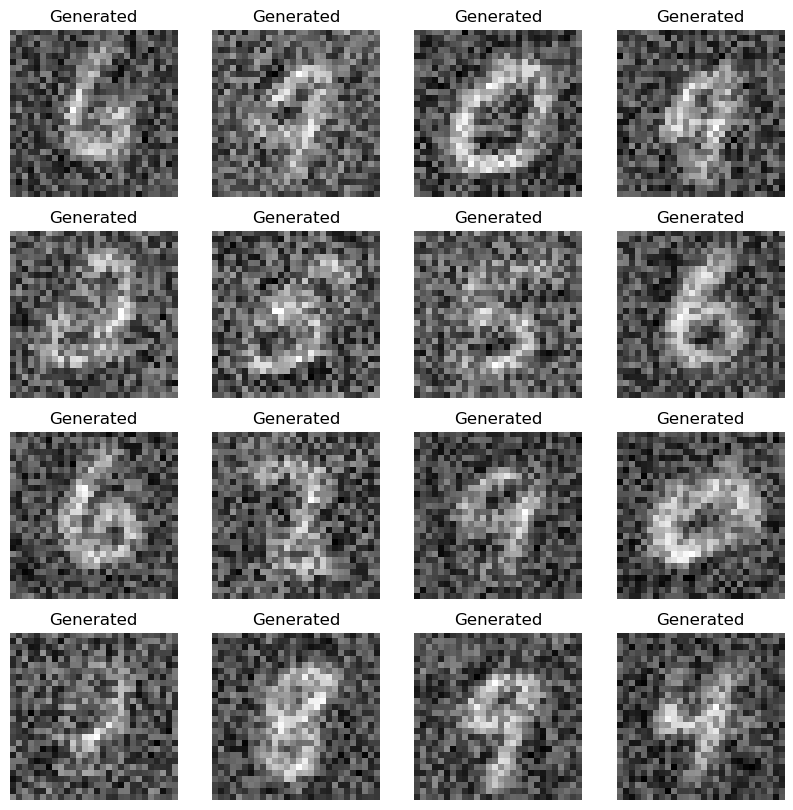

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.01it/s, val_loss=-0.583, clf_loss : =0.105, gen_loss : =-0.688]    


Epoch 18/25, Train Loss: 0.2583, Val Loss: 0.0232


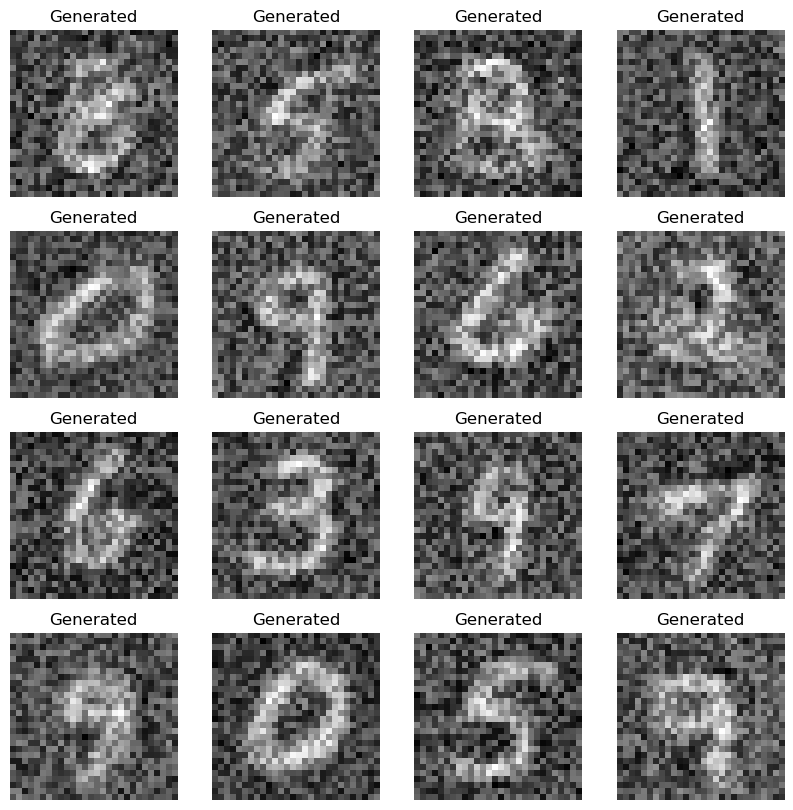

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.10it/s, val_loss=0.755, clf_loss : =0.0814, gen_loss : =0.673]   


Epoch 19/25, Train Loss: 0.2415, Val Loss: 0.4075


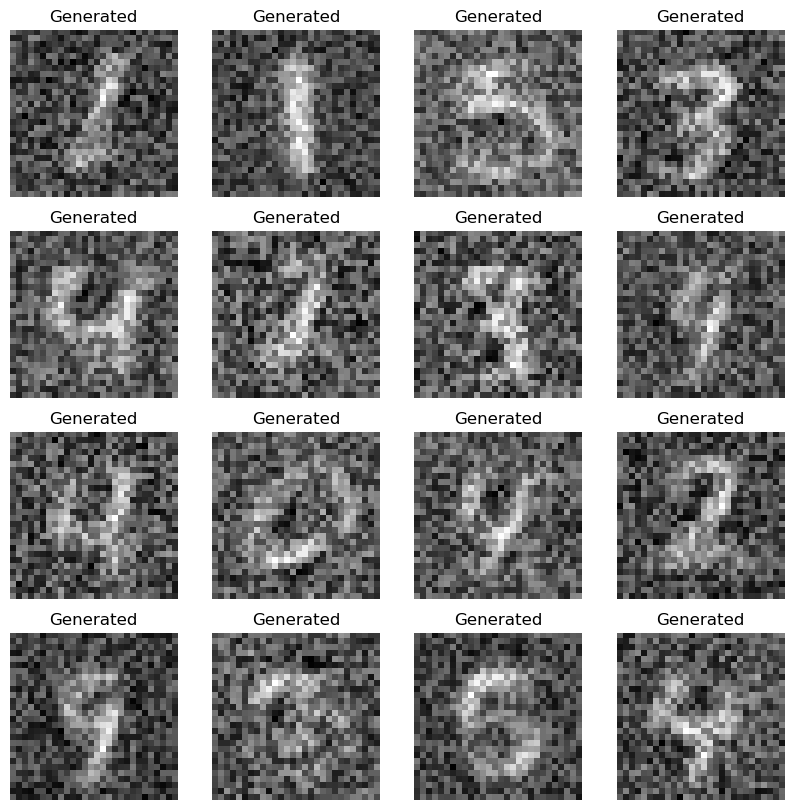

Evaluating: 100%|██████████| 157/157 [00:18<00:00,  8.29it/s, val_loss=0.304, clf_loss : =0.0842, gen_loss : =0.22]     


Epoch 20/25, Train Loss: 0.2375, Val Loss: 0.3727


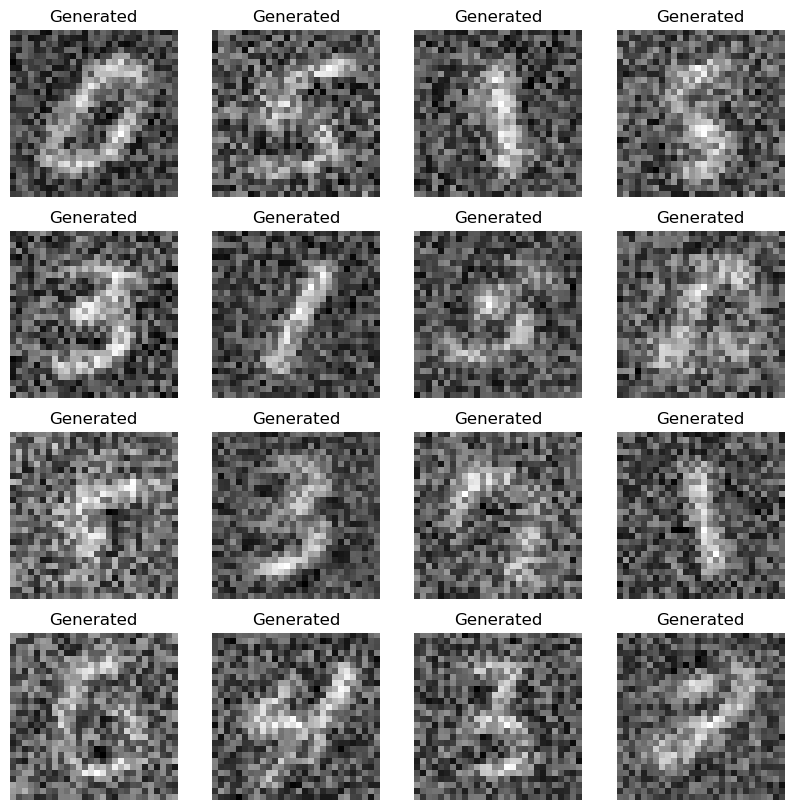

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.18it/s, val_loss=-0.31, clf_loss : =0.0672, gen_loss : =-0.377]    


Epoch 21/25, Train Loss: 0.2335, Val Loss: -0.0186


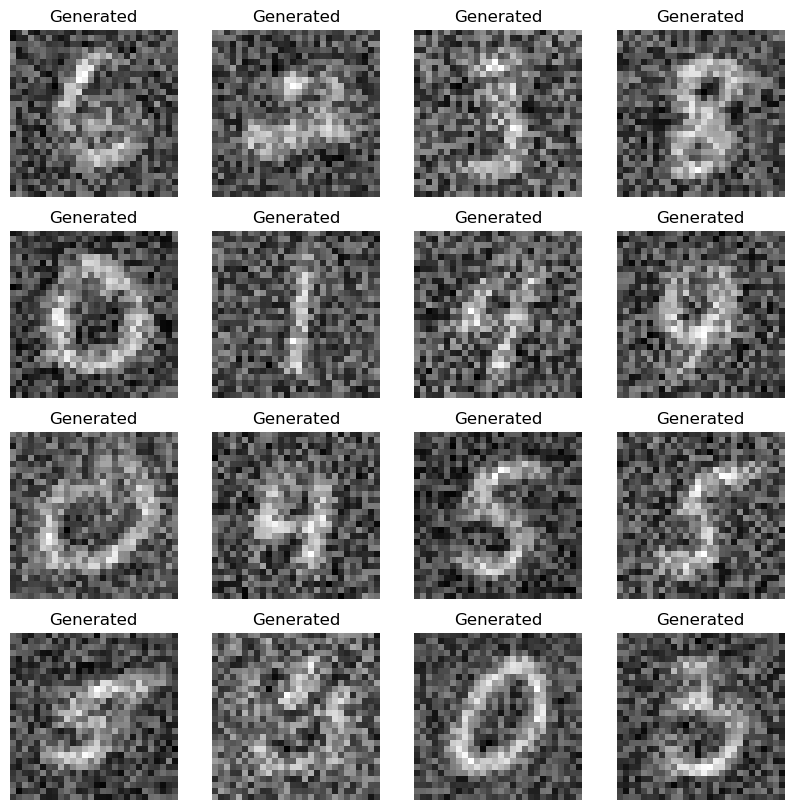

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.09it/s, val_loss=0.991, clf_loss : =0.0711, gen_loss : =0.919]     


Epoch 22/25, Train Loss: 0.2201, Val Loss: 0.1785


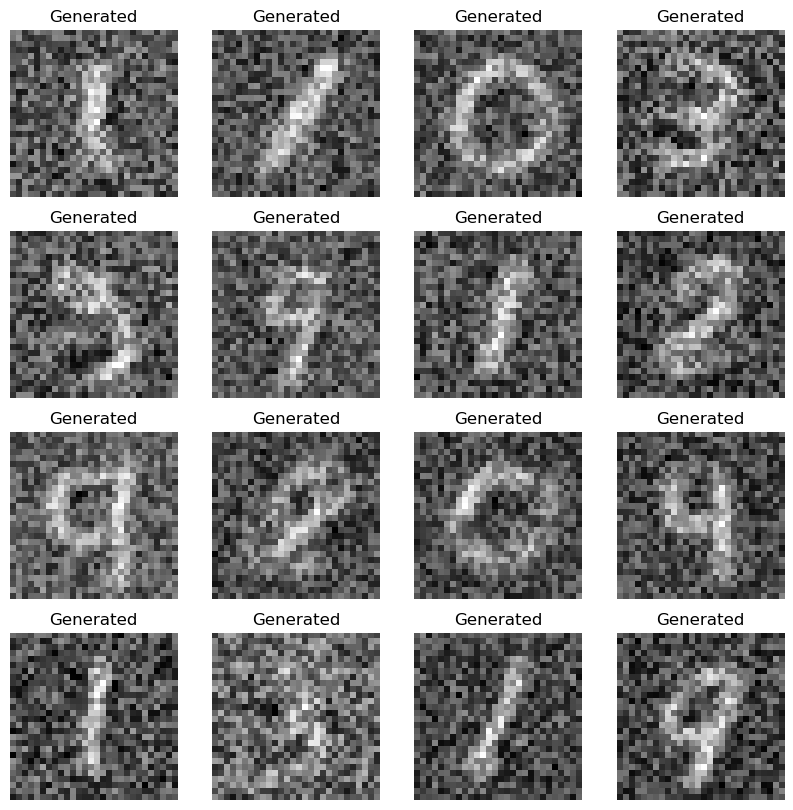

Evaluating: 100%|██████████| 157/157 [00:19<00:00,  8.16it/s, val_loss=0.353, clf_loss : =0.06, gen_loss : =0.293]      


Epoch 23/25, Train Loss: 0.2158, Val Loss: -0.0091


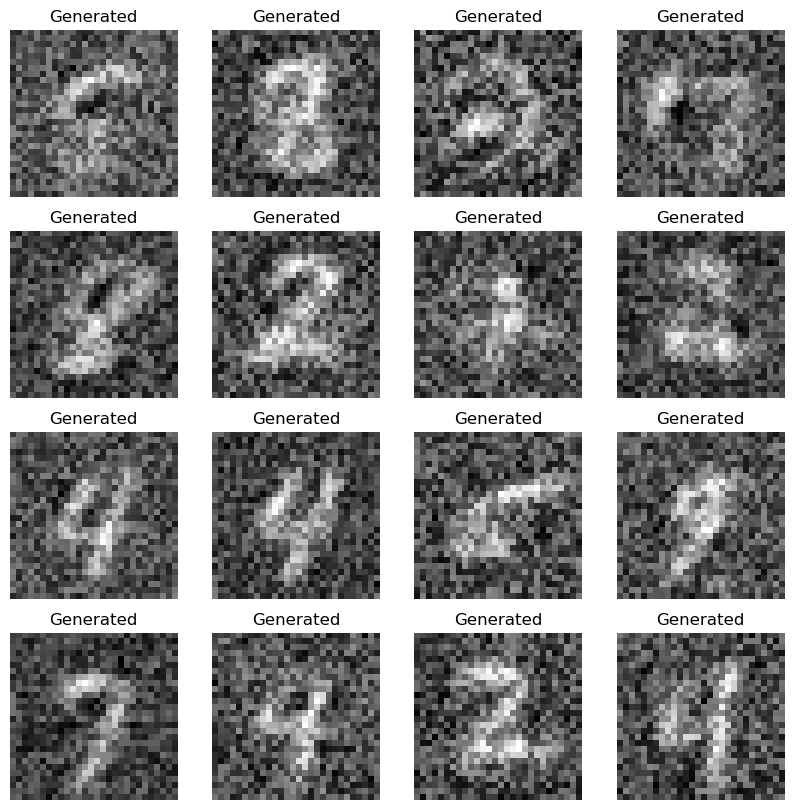

Evaluating: 100%|██████████| 157/157 [00:18<00:00,  8.55it/s, val_loss=-0.686, clf_loss : =0.0714, gen_loss : =-0.757]  


Epoch 24/25, Train Loss: 0.2092, Val Loss: 0.0798


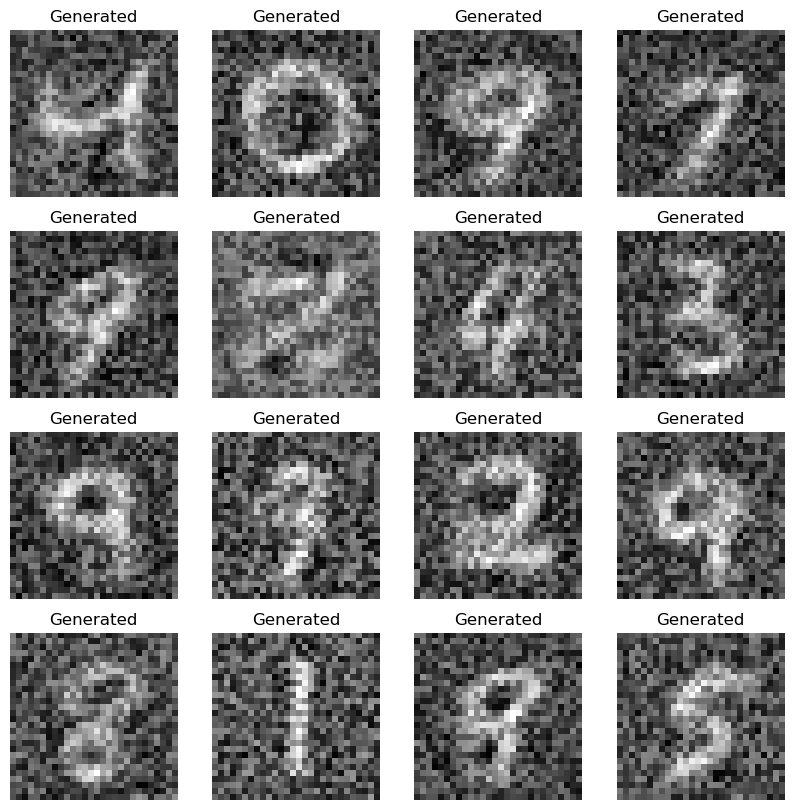

Evaluating: 100%|██████████| 157/157 [00:18<00:00,  8.47it/s, val_loss=-0.337, clf_loss : =0.0627, gen_loss : =-0.4]    


Epoch 25/25, Train Loss: 0.2015, Val Loss: 0.1634


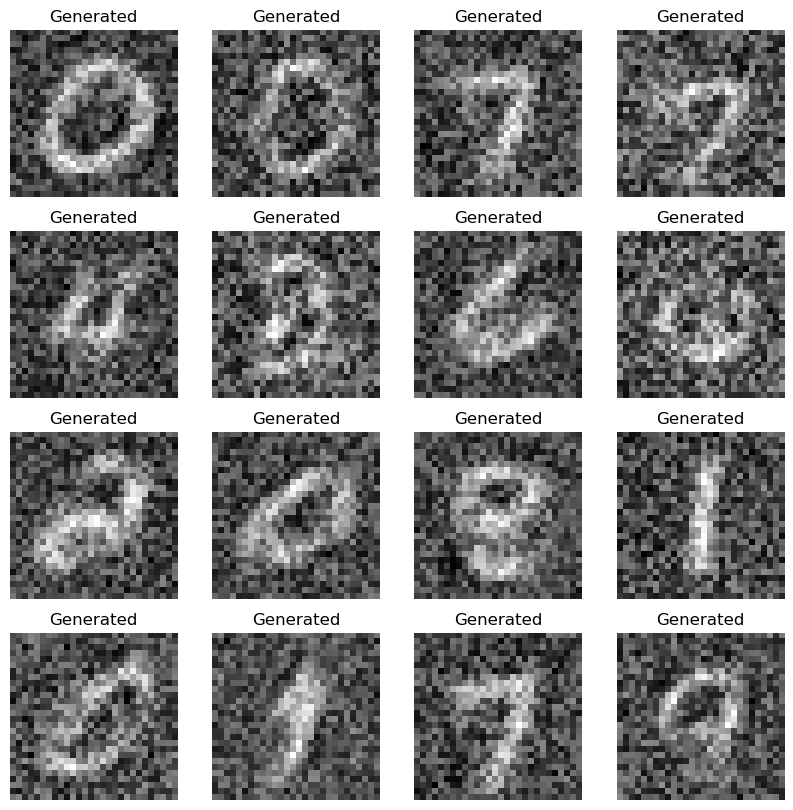

In [53]:
# TODO: Train your EBM
from torch.utils.data import DataLoader, Subset
import imageio.v2 as imageio

subset_dataset = Subset(trainset, indices=range(40960))
subset_train = DataLoader(subset_dataset, batch_size=batch_size, shuffle=False)

subset_dataset2 = Subset(testset, indices=range(4096))
subset_val = DataLoader(subset_dataset2, batch_size=batch_size, shuffle=False)

model = EnergyNet().to(device)
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 25

eta = 50
alpha = 1
sigma = 0.002
train_losses, val_losses = train_ebm(model, optimizer, trainloader, testloader, epochs, eta, alpha, sigma)

Plot the training curve.

In [54]:
torch.load('model.pth')

EnergyNet(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ELU(alpha=1.0)
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

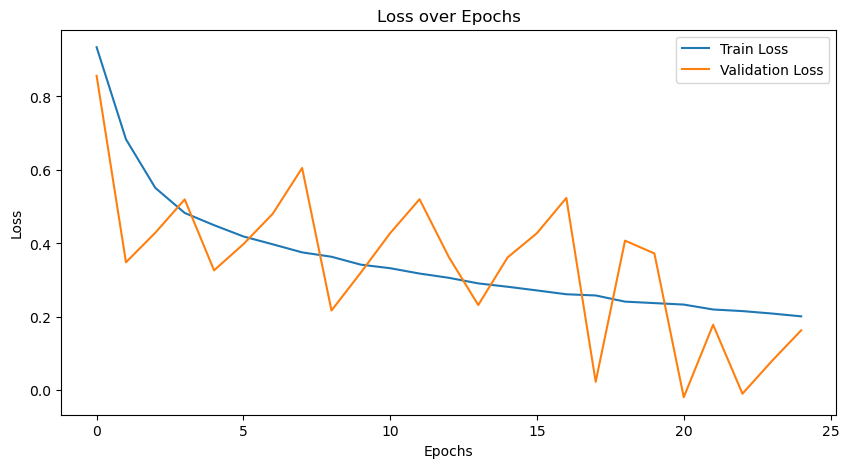

In [55]:
# TODO: Plot loss over epochs
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

Now visualize generated samples. (You can visualize images every few epochs to see the evolution of your network)

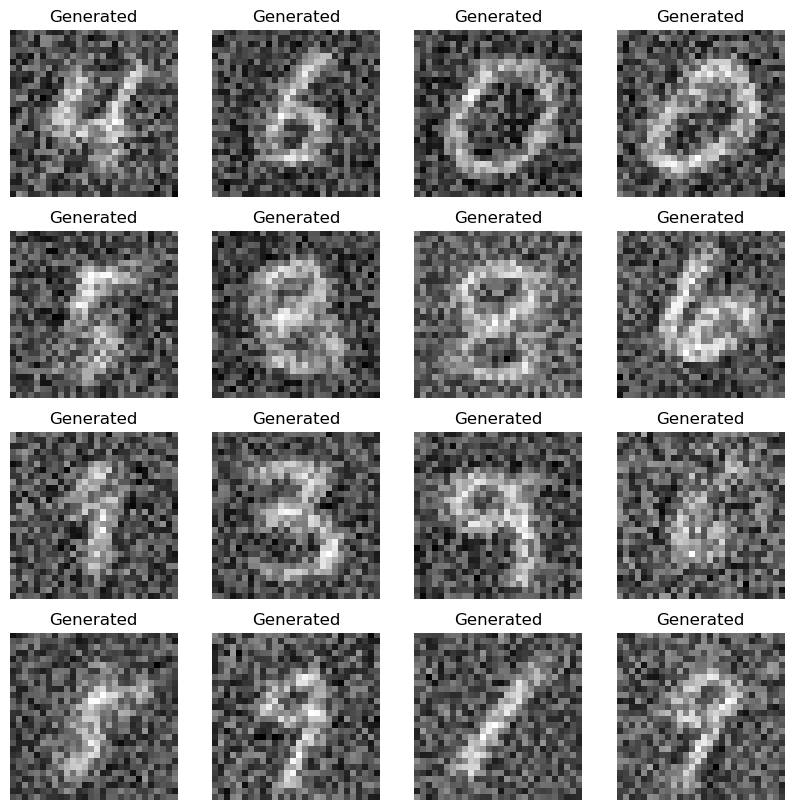

In [56]:
# TODO: Generate and visualize images
visualize_generated(model, eta, alpha, sigma, trainloader)

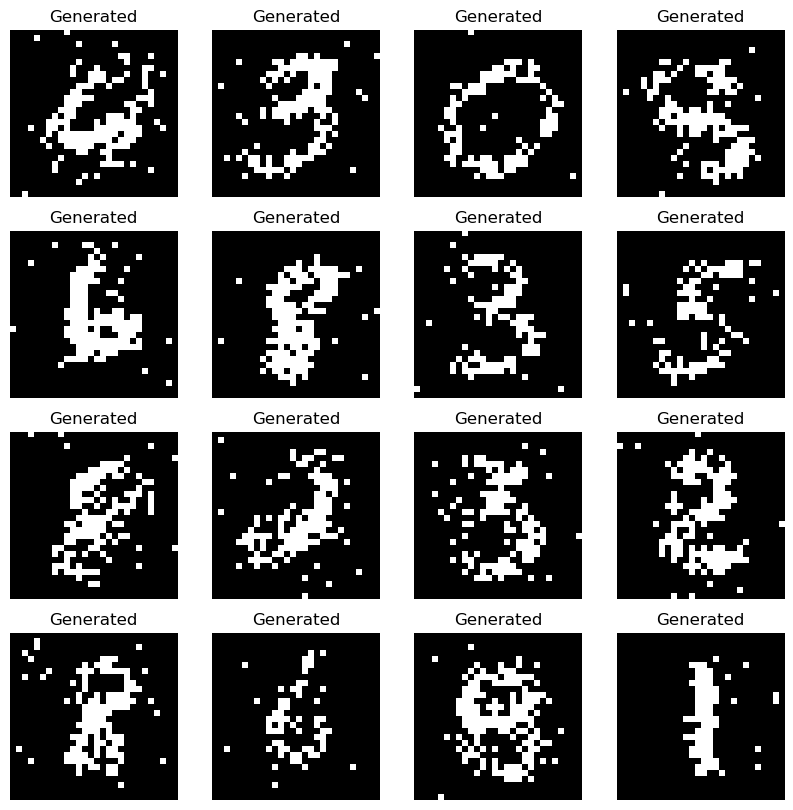

In [57]:
# Generate samples and using sigmoid and change pixels less than 0.5 to 0 and other pixels to 1
def generate_and_visualize_images(model, eta, alpha, sigma, num_samples):
    # Assume the shape argument is batch size and needs 784 features per sample
    generated_images = sample(model, eta, alpha, sigma, num_samples)
    generated_images = torch.sigmoid(generated_images)
    generated_images = (generated_images >= 0.5).float()

    generated_images = generated_images.reshape(-1, 28, 28).detach().cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    for i in range(16):  # Display 16 images
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.title('Generated')
        plt.axis('off')
    plt.show()

generate_and_visualize_images(model, eta, alpha, sigma, 64)

If your resutls aren't great you can tune the hyperparameters to get better results or alternatively you can modify the dataset (resize, ...)to make it easier to learn the energy function.